In [1]:
%matplotlib inline


# Fitting JR model (Tepit data)


## Importage




In [2]:
# os stuff
import os
import sys
sys.path.append('..')
import mne
# whobpyt stuff
import whobpyt
from whobpyt.datatypes import par, Recording
from whobpyt.models.JansenRit import RNNJANSEN, ParamsJR
from whobpyt.optimization.custom_cost_JR import CostsJR
from whobpyt.run import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd
import scipy.io


# viz stuff
import matplotlib.pyplot as plt

#gdown
import gdown

define destination path and download data



In [3]:
des_dir = '../'
if not os.path.exists(des_dir):
    os.makedirs(des_dir)  # create folder if it does not exist
url = 'https://drive.google.com/drive/folders/1uXrtehuMlLBvPCV8zDaUYxF-MoMaD0fk'
os.chdir(des_dir)
gdown.download_folder(url, quiet = True, use_cookies = False)
os.chdir('examples/')

get  EEG data



In [4]:
base_dir = '../Tepit/'
eeg_file = base_dir + 'eeg_data.npy'
eeg_data_all = np.load(eeg_file)
eeg_data = eeg_data_all.mean(0) 

eeg_data = eeg_data[:,700:1100] / 12

get stimulus weights on regions



In [5]:
ki0 =np.loadtxt(base_dir + 'stim_weights.txt')[:,np.newaxis]

get SC and distance template



In [6]:
sc_file = base_dir + 'Schaefer2018_200Parcels_7Networks_count.csv'
dist_file = base_dir + 'Schaefer2018_200Parcels_7Networks_distance.csv'
sc_df = pd.read_csv(sc_file, header=None, sep=' ')
sc = sc_df.values
dist_df = pd.read_csv(dist_file, header=None, sep=' ')
dist = dist_df.values
sc = np.log1p(sc) / np.linalg.norm(np.log1p(sc))

define options for JR model



In [7]:
node_size = sc.shape[0]

output_size = eeg_data.shape[0]
TPperWindow = 20
step_size = 0.0001
num_epochs = 20
tr = 0.001
state_size = 6
base_batch_num = 200
time_dim = 400
state_size = 6
base_batch_num = 20
hidden_size = int(tr/step_size)

prepare data structure of the model



In [8]:
print(eeg_data.shape)
EEGstep = tr
data_mean = Recording(eeg_data, EEGstep) #dataloader(eeg_data.T, num_epochs, batch_size)

(64, 400)


get model parameters structure and define the fitted parameters by setting non-zero variance for the model



In [9]:
lm = np.zeros((output_size,200))
lm_v = np.zeros((output_size,200))
params = ParamsJR(A = par(3.25), a= par(100,100, 2, True, True), B = par(22), b = par(50, 50, 1, True, True), g=par(40,40,2, True, True), g_f=par(1), g_b=par(1), \
                  c1 = par(135, 135, 1, True, True), c2 = par(135*0.8, 135*0.8, 1, True, True), c3 = par(135*0.25, 135*0.25, 1, True, True), c4 = par(135*0.25, 135*0.25, 1, True, True),\
                  std_in= par(1,1, 1/10, True, True), vmax= par(5), v0=par(6), r=par(0.56), y0=par(2, 2, 1/4, True, True),\
                  mu = par(1., 1., 0.4, True, True), #k = [10, .3],
                  #cy0 = [5, 0], ki=[ki0, 0], k_aud=[k_aud0, 0], lm=[lm, 1.0 * np.ones((output_size, 200))+lm_v], \
                  cy0 = par(50, 50, 1, True, True), ki=par(ki0), lm=par(lm, lm, 5 * np.ones((output_size, node_size))+lm_v, True, True))

call model want to fit



In [10]:
model = RNNJANSEN(node_size, TPperWindow, step_size, output_size, tr, sc, lm, dist, True, False, params)

create objective function



In [11]:
ObjFun = CostsJR()

call model fit



In [12]:
F = Model_fitting(model, ObjFun)

## Model Training




In [13]:
u = np.zeros((node_size,hidden_size,time_dim))
u[:,:,110:120]= 200
F.train(u = u, empRecs = [data_mean], num_epochs = num_epochs, TPperWindow = TPperWindow)

Epoch:  0
epoch:  0 loss: -22813.465 Pseudo FC_cor:  0.27915668378951153 cos_sim:  0.03143170640789893
Epoch:  1
epoch:  1 loss: -24701.756 Pseudo FC_cor:  0.18609762722858494 cos_sim:  0.014803823216932493
Epoch:  2
epoch:  2 loss: -26248.51 Pseudo FC_cor:  0.46712350388198187 cos_sim:  0.10106820886649462
Epoch:  3
epoch:  3 loss: -27553.186 Pseudo FC_cor:  0.38810389283410673 cos_sim:  0.11486314456367222
Epoch:  4
epoch:  4 loss: -28682.656 Pseudo FC_cor:  0.8931057699770383 cos_sim:  0.3780296962362365
Epoch:  5
epoch:  5 loss: -29680.242 Pseudo FC_cor:  0.925048864227513 cos_sim:  0.374503160579539
Epoch:  6
epoch:  6 loss: -30574.78 Pseudo FC_cor:  0.8348438599983576 cos_sim:  0.3187743707546748
Epoch:  7
epoch:  7 loss: -31386.412 Pseudo FC_cor:  0.8703016069978274 cos_sim:  0.34647690608102477
Epoch:  8
epoch:  8 loss: -32129.943 Pseudo FC_cor:  0.8377273199778654 cos_sim:  0.40021597636045175
Epoch:  9
epoch:  9 loss: -32816.227 Pseudo FC_cor:  0.9138750729998589 cos_sim:  0.

Plots of loss over Training



Text(0.5, 1.0, 'Total Loss over Training Epochs')

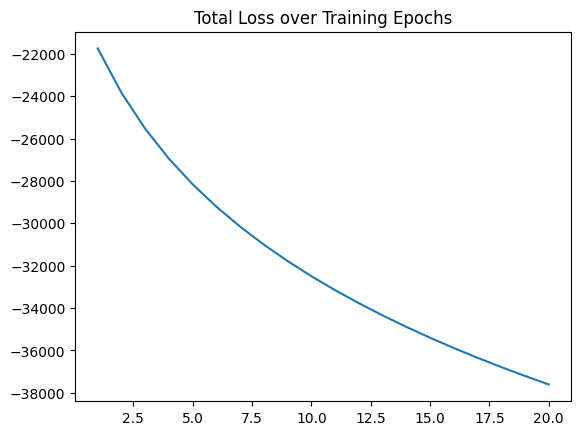

In [14]:
plt.plot(np.arange(1,len(F.trainingStats.loss)+1), F.trainingStats.loss)
plt.title("Total Loss over Training Epochs")

Plots of parameter values over Training



Text(0.5, 1.0, 'Select Variables Changing Over Training Epochs')

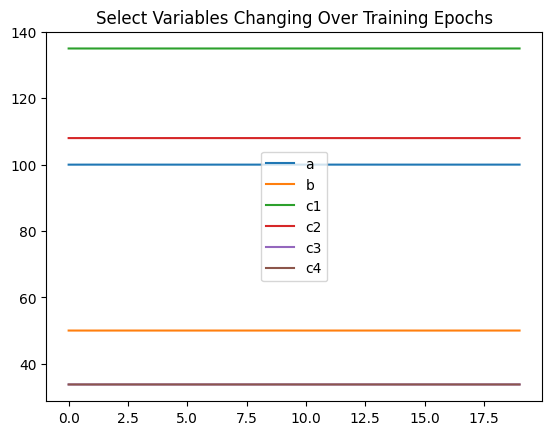

In [15]:
plt.plot(F.trainingStats.fit_params['a'], label = "a")
plt.plot(F.trainingStats.fit_params['b'], label = "b")
plt.plot(F.trainingStats.fit_params['c1'], label = "c1")
plt.plot(F.trainingStats.fit_params['c2'], label = "c2")
plt.plot(F.trainingStats.fit_params['c3'], label = "c3")
plt.plot(F.trainingStats.fit_params['c4'], label = "c4")
plt.legend()
plt.title("Select Variables Changing Over Training Epochs")

## Model Evaluation (with 20 window for warmup)




In [16]:
F.evaluate(u = u, empRec = data_mean, TPperWindow = TPperWindow, base_window_num = 20)

FC_cor:  0.9199609099100113 cos_sim:  0.4348310857852401


Plot SC and fitted SC



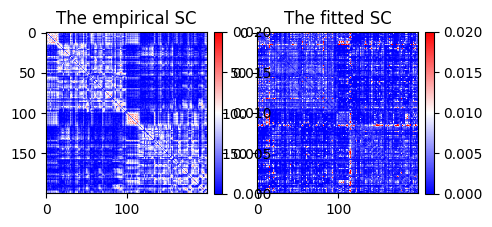

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(5, 4))
im0 = ax[0].imshow(sc, cmap='bwr', vmin = 0.0, vmax = 0.02)
ax[0].set_title('The empirical SC')
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
im1 = ax[1].imshow(F.model.sc_fitted.detach().numpy(), cmap='bwr', vmin = 0.0, vmax = 0.02)
ax[1].set_title('The fitted SC')
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
plt.show()

Plot the EEG



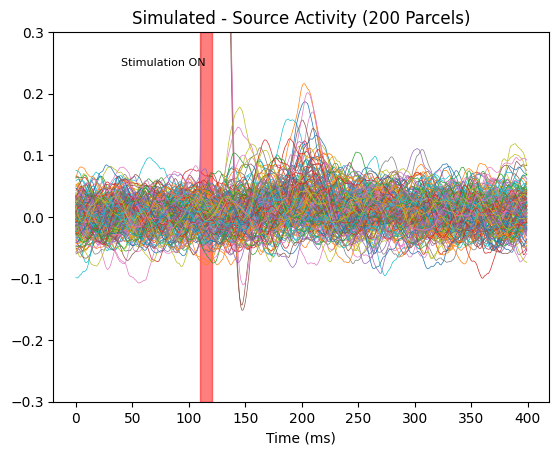

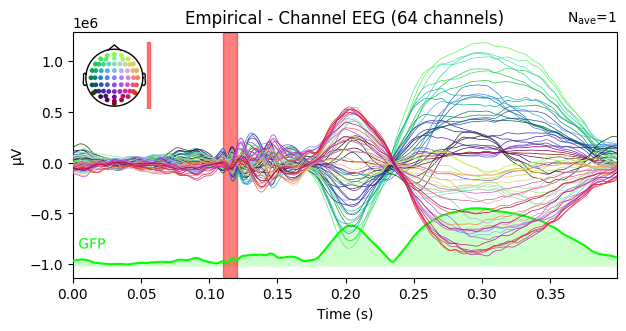

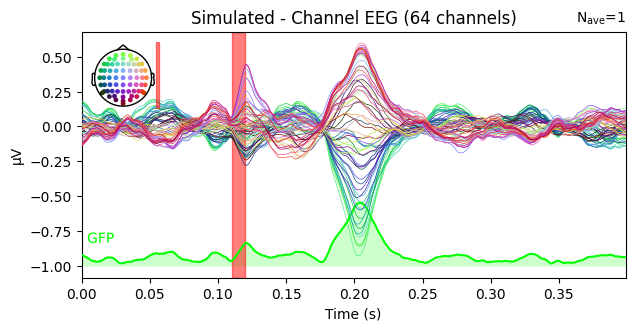

In [18]:
# Plotting the timeseries of the fitted model and the empirical data using mne package

# import a 64 channel montage for visualization
montage = mne.channels.make_standard_montage('biosemi64')
# create info object based on the montage
info = mne.create_info(ch_names = montage.ch_names, sfreq = 1000, ch_types = 'eeg')

# create mne.evoked objects
evoked_emp = mne.EvokedArray(eeg_data, info)
evoked_emp.set_montage(montage)
evoked_fit = mne.EvokedArray(F.lastRec["eeg"].npTS()/1e6, info)
evoked_fit.set_montage(montage)

plt.plot(F.lastRec['P'].npTS().T, linewidth = 0.5)
# resize plot
plt.rcParams["figure.figsize"] = (8, 3)
plt.title('Simulated - Source Activity (200 Parcels)');
plt.ylim(-.3, .3);
# add x label
plt.xlabel('Time (ms)');
# add bar between 110 and 120 for stimulus
plt.axvspan(110, 120, alpha=0.5, color='red');
# add label for stimulus
plt.text(115, .25, 'Stimulation ON', color='black', fontsize=8, horizontalalignment='right', verticalalignment='center');

fig = evoked_emp.plot(gfp=True, time_unit='s', show=False, titles='Empirical - Channel EEG')
for ax in fig.axes:
    ax.axvspan(0.11, 0.12, alpha=0.5, color='red');
    

fig = evoked_fit.plot(gfp=True, time_unit='s', show=False, titles='Simulated - Channel EEG');
for ax in fig.axes:
    ax.axvspan(0.11, 0.12, alpha=0.5, color='red');


### Validating correct parameter fitting


In [24]:
# os.chdir('../whobpyt/unittests/')
from param_fitting_test import check_fit_integrity
check_fit_integrity(F)

Score: Pass for RNNJANSEN() on A 


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on A 


Score: Pass for RNNJANSEN() on a


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on a


Score: Pass for RNNJANSEN() on B


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on B


Score: Pass for RNNJANSEN() on b


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on b


Score: Pass for RNNJANSEN() on g


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on g


Score: Pass for RNNJANSEN() on c1


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on c1


Score: Pass for RNNJANSEN() on c2


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on c2


Score: Pass for RNNJANSEN() on c3 


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on c3 


Score: Pass for RNNJANSEN() on c4


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on c4


Score: Pass for RNNJANSEN() on std_in


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on std_in


Score: Pass for RNNJANSEN() on vmax


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on vmax


Score: Pass for RNNJANSEN() on v0


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on v0


Score: Pass for RNNJANSEN() on r


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on r


Score: Pass for RNNJANSEN() on y0


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on y0


Score: Fail for RNNJANSEN() on mu


Level 100:sciunit_scores:Score: Fail for RNNJANSEN() on mu


Score: Pass for RNNJANSEN() on k


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on k


Score: Pass for RNNJANSEN() on cy0


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on cy0


Score: Pass for RNNJANSEN() on ki


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on ki


Score: Pass for RNNJANSEN() on A


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on A


Score: Pass for RNNJANSEN() on g_f


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on g_f


Score: Pass for RNNJANSEN() on g_b


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on g_b


Score: Pass for RNNJANSEN() on c3


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on c3


Score: Pass for RNNJANSEN() on lm


Level 1:sciunit_scores:Score: Pass for RNNJANSEN() on lm


TypeError: copy() got an unexpected keyword argument 'deep'

               A      a     B     b     g    c1    c2   c3     c4 std_in  ...  \
RNNJANSEN()  Pass  Pass  Pass  Pass  Pass  Pass  Pass  Pass  Pass   Pass  ...   

               y0    mu     k   cy0    ki     A   g_f   g_b    c3    lm  
RNNJANSEN()  Pass  Fail  Pass  Pass  Pass  Pass  Pass  Pass  Pass  Pass  

[1 rows x 23 columns]